In [1]:
using CSV, DataFrames
# D = demand matrix (day of the week)
# n locations
# W = foot-traffic matrix (for each location, foot traffic for day of the week)

D = CSV.read("electricity/demand.csv", DataFrame; header=true)[:, 2]#7x1
mean_counts_df = CSV.read("ped_traffic/mean_counts.csv", DataFrame; header=true)
W = mean_counts_df[:, 3:9]|> Matrix #110x7
location_ids = mean_counts_df[:, 1] # location IDs

mean_counts_df2 = CSV.read("ped_traffic/mean_counts_dist.csv", DataFrame; header=true)
W2 = mean_counts_df2[:, 3:9]|> Matrix #44x7
d = mean_counts_df2[:, 10] #44x1
location_ids2 = mean_counts_df2[:, 1] # location IDs

println(size(D))
println(size(W))
println(size(W2))
println(size(d))

(7,)
(110, 7)
(44, 7)
(44,)


# Number of Locations Minimization Optimization

In [2]:
using JuMP
using HiGHS
using LinearAlgebra

percent_demand = 0.00001
watts_converted = 0.1

function optimize_installations(D::Vector{Float64}, W::Matrix{Float64})

    n, T = size(W)  # n locations, T = 7 days
    @assert length(D) == T "Demand vector D must have length 7"

    model = Model(HiGHS.Optimizer)
    
    set_silent(model)

    @variable(model, x[1:n], Bin) # int decision vars

    @objective(model, Min, sum(x[i] for i in 1:n)) # objective func

    for t in 1:T # constraint each day
        @constraint(model, sum(W[i, t] * x[i] * watts_converted for i in 1:n) ≥ percent_demand * D[t])
    end

    optimize!(model) # solve model

    status = termination_status(model)
    if status != MOI.OPTIMAL
        println("Warning: Solver returned status $status")
    end

    chosen_locations = findall(i -> value(x[i]) > 0.5, 1:n)
    min_num_locations = length(chosen_locations)

    return min_num_locations, chosen_locations, model
end

optimize_installations (generic function with 1 method)

In [3]:
min_locs, chosen, model = optimize_installations(D, W)
println("Minimum number of locations needed: ", min_locs)
println("Chosen location indices: ", chosen)

Minimum number of locations needed: 4
Chosen location indices: [15, 17, 19, 78]


In [4]:
min_locs, chosen, model = optimize_installations(D, W2)
println("Minimum number of locations needed: ", min_locs)
println("Chosen location indices: ", chosen)

Minimum number of locations needed: 4
Chosen location indices: [6, 10, 20, 24]


In [5]:
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
energy_produced = zeros(7)
energy_needed = percent_demand .* D

println(chosen)

for t in 1:7
    for i in chosen
        energy_produced[t] += W[i, t] * 0.1
        # energy_produced[t] += W2[i, t] * 0.1
    end
end

energy_comparison = DataFrame(
    Day = days,
    Energy_Produced = energy_produced,
    Energy_Needed = energy_needed,
    Surplus = energy_produced .- energy_needed,
)

println("=" ^ 70)
println("Energy Production vs Demand Analysis")
println("=" ^ 70)
println(energy_comparison)
println()


[6, 10, 20, 24]
Energy Production vs Demand Analysis
7×4 DataFrame
 Row │ Day        Energy_Produced  Energy_Needed  Surplus  
     │ String     Float64          Float64        Float64  
─────┼─────────────────────────────────────────────────────
   1 │ Monday              415.45        1144.2   -728.754
   2 │ Tuesday             415.45        1181.74  -766.295
   3 │ Wednesday           415.45        1191.14  -775.693
   4 │ Thursday            415.45        1190.01  -774.564
   5 │ Friday              415.45        1161.43  -745.984
   6 │ Saturday            411.9         1054.46  -642.559
   7 │ Sunday              419.0         1061.85  -642.848



In [6]:
total_foot_traffic = [sum(W[i, :]) for i in 1:size(W, 1)]

println(chosen)

location_traffic = DataFrame(
    Index = 1:size(W, 1),
    Total_Foot_Traffic = total_foot_traffic
)
sort!(location_traffic, :Total_Foot_Traffic, rev=true)

println("=" ^ 70)
println("Top 10 Locations by Total Foot Traffic")
println("=" ^ 70)
println(first(location_traffic, 10))

[6, 10, 20, 24]
Top 10 Locations by Total Foot Traffic
10×2 DataFrame
 Row │ Index  Total_Foot_Traffic 
     │ Int64  Float64            
─────┼───────────────────────────
   1 │    15            34608.0
   2 │    20            24220.0
   3 │    19            20345.5
   4 │     9            18670.8
   5 │    78            16989.0
   6 │    75            14568.8
   7 │    17            14199.5
   8 │    31            14115.6
   9 │    57            11077.5
  10 │    58             9805.69


# Distance Minimization Optimization

In [ ]:
using JuMP
using HiGHS
using LinearAlgebra

percent_demand = 0.00001
watts_converted = 0.1

function optimize_installations_dist(D::Vector{Float64}, W::Matrix{Float64}, d::Vector{Float64}, max_loc)

    n, T = size(W)  # n locations, T = 7 days
    @assert length(D) == T "Demand vector D must have length 7"
    @assert length(d) == n "Distance vector d must have length n"

    model = Model(HiGHS.Optimizer)
    
    set_silent(model)

    @variable(model, x[1:n], Bin) # int decision vars

    @objective(model, Min, sum((d[i]*d[i] + d[i]) * x[i] for i in 1:n))

    @constraint(model, sum(x[i] for i in 1:n) ≤ max_loc)
    for t in 1:T
        @constraint(model, sum(W[i, t] * x[i] * watts_converted for i in 1:n) ≥ percent_demand * D[t])
    end

    optimize!(model)

    status = termination_status(model)
    if status != MOI.OPTIMAL
        println("Warning: Solver returned status $status")
    end

    chosen_locations = findall(i -> value(x[i]) > 0.5, 1:n)
    total_distance = sum(d[i] for i in chosen_locations)
    num_locations = length(chosen_locations)

    return num_locations, chosen_locations, total_distance, model
end

optimize_installations_dist (generic function with 1 method)

In [9]:
num_locs, chosen, total_dist, model = optimize_installations_dist(D, W2, d, 7)
total_objective = sum(d[i]*d[i]+d[i] for i in chosen)

println("Number of locations selected: ", num_locs)
println("Chosen location indices: ", chosen)
println("Total distance to City Hall: ", total_dist, " miles")
println("Total objective value: ", total_objective)

Number of locations selected: 5
Chosen location indices: [5, 6, 9, 10, 14]
Total distance to City Hall: 5.663774772660714 miles
Total objective value: 14.853060217024849


In [11]:
num_locs, chosen, total_dist, model = optimize_installations_dist(D, W2, d, 4)
total_objective = sum(d[i]*d[i]+d[i] for i in chosen)

println("Number of locations selected: ", num_locs)
println("Chosen location indices: ", chosen)
println("Total distance to City Hall: ", total_dist, " miles")
println("Total objective value: ", total_objective)

Number of locations selected: 4
Chosen location indices: [6, 9, 10, 34]
Total distance to City Hall: 5.368448838796317 miles
Total objective value: 14.91512325402067


In [14]:
num_locs, chosen, total_dist, model = optimize_installations_dist(D, W2, d, 3)
total_objective = sum(d[i]*d[i]+d[i] for i in chosen)

println("Number of locations selected: ", num_locs)
println("Chosen location indices: ", chosen)
println("Total distance to City Hall: ", total_dist, " miles")
println("Total objective value: ", total_objective)

LoadError: ArgumentError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer

In [15]:
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
energy_produced = zeros(7)
energy_needed = percent_demand .* D

println(chosen)

for t in 1:7
    for i in chosen
        # energy_produced[t] += W[i, t] * 0.1
        energy_produced[t] += W2[i, t] * 0.1
    end
end

energy_comparison = DataFrame(
    Day = days,
    Energy_Produced = energy_produced,
    Energy_Needed = energy_needed,
    Surplus = energy_produced .- energy_needed,
)

println("=" ^ 70)
println("Energy Production vs Demand Analysis")
println("=" ^ 70)
println(energy_comparison)
println()


[6, 9, 10, 34]
Energy Production vs Demand Analysis
7×4 DataFrame
 Row │ Day        Energy_Produced  Energy_Needed  Surplus   
     │ String     Float64          Float64        Float64   
─────┼──────────────────────────────────────────────────────
   1 │ Monday             1197.35        1144.2    53.1456
   2 │ Tuesday            1197.35        1181.74   15.6051
   3 │ Wednesday          1197.35        1191.14    6.20684
   4 │ Thursday           1197.35        1190.01    7.33593
   5 │ Friday             1197.35        1161.43   35.9159
   6 │ Saturday           1197.35        1054.46  142.891
   7 │ Sunday             1197.35        1061.85  135.502



In [16]:
total_foot_traffic = [sum(W2[i, :]) for i in 1:size(W2, 1)]

println(chosen)
location_traffic = DataFrame(
    Index = 1:size(W2, 1),
    Total_Foot_Traffic = total_foot_traffic
)
sort!(location_traffic, :Total_Foot_Traffic, rev=true)

println("=" ^ 70)
println("Top 10 Locations by Total Foot Traffic")
println("=" ^ 70)
println(first(location_traffic, 10))

[6, 9, 10, 34]
Top 10 Locations by Total Foot Traffic
10×2 DataFrame
 Row │ Index  Total_Foot_Traffic 
     │ Int64  Float64            
─────┼───────────────────────────
   1 │     6            34608.0
   2 │    10            24220.0
   3 │     9            20345.5
   4 │    24            14568.8
   5 │     8            14199.5
   6 │    20            11077.5
   7 │    33             9224.25
   8 │     7             5005.0
   9 │    36             4739.0
  10 │    34             4641.0


In [18]:
selected_locations = DataFrame(
    Index = 1:size(W2, 1),
    Distance_miles = d
)

println(chosen)
sort!(selected_locations, :Distance_miles)

println("=" ^ 70)
println("Selected Locations Sorted by Distance to City Hall")
println("=" ^ 70)
println(first(selected_locations, 10))


[6, 9, 10, 34]
Selected Locations Sorted by Distance to City Hall
10×2 DataFrame
 Row │ Index  Distance_miles 
     │ Int64  Float64        
─────┼───────────────────────
   1 │    10        0.357348
   2 │     2        0.380489
   3 │    15        0.662542
   4 │    16        0.662542
   5 │    14        0.693014
   6 │     1        0.854314
   7 │     5        0.854314
   8 │    34        1.252
   9 │     6        1.25263
  10 │    39        1.42072


# Robust Opt

### Element-Wise Robustness

In [19]:
using JuMP
using HiGHS
using LinearAlgebra
using Statistics

percent_demand = 0.00001
watts_converted = 0.1

function optimize_installations_dist_robust(
    D_mean::Vector{Float64},      # Mean demand vector
    D_std::Vector{Float64},        # Standard deviation of demand
    W_mean::Matrix{Float64},       # Mean traffic matrix
    W_std::Matrix{Float64},        # Standard deviation of traffic matrix
    d::Vector{Float64},            # Distance vector
    k = 2.0,              # Uncertainty parameter (k standard deviations)
    max_loc = 1000               # Maximum number of locations
)

    n, T = size(W_mean)  # n locations, T = 7 days
    @assert length(D_mean) == T "Demand vector must have length 7"
    @assert length(D_std) == T "Demand std vector must have length 7"
    @assert size(W_std) == size(W_mean) "W_std must have same size as W_mean"
    @assert length(d) == n "Distance vector d must have length n"

    model = Model(HiGHS.Optimizer)
    set_silent(model)

    @variable(model, x[1:n], Bin) # Binary decision variables

    # Objective: minimize e^distance - 1 for selected locations
    @objective(model, Min, sum((d[i]*d[i] + d[i]) * x[i] for i in 1:n))

    # Constraint: maximum locations can be selected
    @constraint(model, sum(x[i] for i in 1:n) ≤ max_loc)

    # Robust constraint: energy production must meet demand each day
    # For worst-case scenario: minimum energy production ≥ maximum demand
    # Worst-case energy production: W_mean - k*W_std (conservative)
    # Worst-case demand: D_mean + k*D_std (conservative)
    for t in 1:T
        # Robust constraint: must satisfy for worst-case (minimum traffic, maximum demand)
        @constraint(model, 
            sum((W_mean[i, t] - k * W_std[i, t]) * x[i] * watts_converted for i in 1:n) 
            ≥ percent_demand * (D_mean[t] + k * D_std[t])
        )
    end

    optimize!(model) # solve model

    status = termination_status(model)
    if status != MOI.OPTIMAL
        println("Warning: Solver returned status $status")
    end

    chosen_locations = findall(i -> value(x[i]) > 0.5, 1:n)
    total_distance = sum(d[i] for i in chosen_locations)
    num_locations = length(chosen_locations)

    return num_locations, chosen_locations, total_distance, model
end


optimize_installations_dist_robust (generic function with 3 methods)

In [20]:
# future work: compute D_mean, D_std, W_mean, W_std from historical data
D_mean_robust = D
D_std_robust = 0.1 .* D_mean_robust # Assume 10% coefficient of variation for demand (std = 0.1 * mean)

W_mean_robust = W2
W_std_robust = max.(0.15 .* W_mean_robust, 0.01) # Assume 15% coefficient of variation for traffic (std = 0.15 * mean); ensure non-negative standard deviations

44×7 Matrix{Float64}:
  45.2188    47.3375   34.9875   43.1875    19.3875   45.2188    45.2188
  12.225     12.225    12.225    12.225     12.225    12.225     12.225
  72.15     118.95     71.175    72.15      72.15     52.425     46.05
  80.85      80.85     80.85    103.8       80.85     57.9       80.85
  78.575     77.6625   54.925   105.9       78.575    78.575     78.575
 741.6      741.6     741.6     741.6      741.6     741.6      741.6
 107.25     123.6     107.25     90.9      107.25    107.25     107.25
 304.275    304.275   304.275   304.275    304.275   304.275    304.275
 435.975    435.975   435.975   435.975    435.975   435.975    435.975
 519.0      519.0     519.0     519.0      519.0     519.0      519.0
  93.075     93.075    93.075    93.075     93.075    93.075     93.075
  24.0       24.0      24.0      24.0       24.0      24.0       24.0
  16.5       16.5      16.5      16.5       16.5      16.5       16.5
   ⋮                                                

In [21]:
num_locs_robust, chosen_robust, total_dist_robust, model_robust = 
    optimize_installations_dist_robust(
        D_mean_robust, D_std_robust, 
        W_mean_robust, W_std_robust, 
        d, 
        1 # set uncertainty parameter k (e.g., k=2.0 means protect against 2 standard deviations)
    )
total_objective_robust = sum(d[i]*d[i] + d[i] for i in chosen_robust)

println("Robust Optimization Results:")
println("Number of locations selected: ", num_locs_robust)
println("Chosen location indices: ", chosen_robust)
println("Total distance to City Hall: ", total_dist_robust, " miles")
println("Total objective value: ", total_objective_robust)
println()

Robust Optimization Results:
Number of locations selected: 8
Chosen location indices: [2, 5, 6, 9, 10, 20, 33, 34]
Total distance to City Hall: 11.930138114407214 miles
Total objective value: 36.58894197016831



In [22]:
num_locs_robust, chosen_robust, total_dist_robust, model_robust = 
    optimize_installations_dist_robust(
        D_mean_robust, D_std_robust, 
        W_mean_robust, W_std_robust, 
        d, 
        2 # set uncertainty parameter k (e.g., k=2.0 means protect against 2 standard deviations)
    )
total_objective_robust = sum(d[i]*d[i] + d[i] for i in chosen_robust)

println("Robust Optimization Results:")
println("Number of locations selected: ", num_locs_robust)
println("Chosen location indices: ", chosen_robust)
println("Total distance to City Hall: ", total_dist_robust, " miles")
println("Total objective value: ", total_objective_robust)
println()

Robust Optimization Results:
Number of locations selected: 12
Chosen location indices: [1, 4, 5, 6, 8, 9, 10, 14, 20, 24, 33, 34]
Total distance to City Hall: 23.19224206236305 miles
Total objective value: 87.59255751649552



In [23]:
num_locs_robust, chosen_robust, total_dist_robust, model_robust = 
    optimize_installations_dist_robust(
        D_mean_robust, D_std_robust, 
        W_mean_robust, W_std_robust, 
        d, 
        1, # set uncertainty parameter k (e.g., k=2.0 means protect against 2 standard deviations)
        7 # set max_loc param
    )
total_objective_robust = sum(d[i]*d[i] + d[i] for i in chosen_robust)

println("Robust Optimization Results:")
println("Number of locations selected: ", num_locs_robust)
println("Chosen location indices: ", chosen_robust)
println("Total distance to City Hall: ", total_dist_robust, " miles")
println("Total objective value: ", total_objective_robust)
println()

Robust Optimization Results:
Number of locations selected: 7
Chosen location indices: [4, 6, 9, 10, 20, 33, 34]
Total distance to City Hall: 12.448047779244629 miles
Total objective value: 39.304228210237355



In [24]:
num_locs_robust, chosen_robust, total_dist_robust, model_robust = 
    optimize_installations_dist_robust(
        D_mean_robust, D_std_robust, 
        W_mean_robust, W_std_robust, 
        d, 
        1, # set uncertainty parameter k (e.g., k=2.0 means protect against 2 standard deviations)
        6 # set max_loc param
    )
total_objective_robust = sum(d[i]*d[i] + d[i] for i in chosen_robust)

println("Robust Optimization Results:")
println("Number of locations selected: ", num_locs_robust)
println("Chosen location indices: ", chosen_robust)
println("Total distance to City Hall: ", total_dist_robust, " miles")
println("Total objective value: ", total_objective_robust)
println()

Robust Optimization Results:
Number of locations selected: 6
Chosen location indices: [6, 8, 9, 10, 20, 34]
Total distance to City Hall: 11.7262602592006 miles
Total objective value: 41.740017651150765



### Global Robustness

In [60]:
using JuMP
using Gurobi
using LinearAlgebra

function optimize_installations_dist_robust_global(
    D_mean::Vector{Float64},      
    D_std::Vector{Float64},       
    W_mean::Matrix{Float64},      
    W_std::Matrix{Float64},       
    d::Vector{Float64},           
    k = 2.0,                       
    max_loc = 1000
)

    n, T = size(W_mean)

    model = Model(Gurobi.Optimizer)
    set_silent(model)
    set_optimizer_attribute(model, "OutputFlag", 0)
    set_optimizer_attribute(model, "LogToConsole", 0)

    @variable(model, x[1:n], Bin)
    @variable(model, aux[1:T] ≥ 0)

    @objective(model, Min, sum((d[i] * d[i] + d[i]) * x[i] for i in 1:n))
    @constraint(model, sum(x) ≤ max_loc)

    for t in 1:T
        # SOCP constraint for uncertainty budget
        @constraint(model,
            [aux[t];  [W_std[i,t] * x[i] for i in 1:n]...] in SecondOrderCone()
        )

        @constraint(model,
            sum(W_mean[i,t] * x[i] for i in 1:n)
            - k * sqrt(n) * aux[t]
            ≥ percent_demand * (D_mean[t] + k * D_std[t])
        )
    end

    optimize!(model)

    chosen = findall(i -> value(x[i]) > 0.5, 1:n)
    total_dist = sum(d[i] for i in chosen)

    return length(chosen), chosen, total_dist, model
end


optimize_installations_dist_robust_global (generic function with 3 methods)

In [61]:
num_locs_g, chosen_g, total_dist_g, model_g =
    optimize_installations_dist_robust_global(
        D_mean_robust, D_std_robust,
        W_mean_robust, W_std_robust,
        d, 
        1,  # k
        6   # max_loc
    )

println("Robust 2 Global Results:")
println("Locations selected: ", num_locs_g)
println("Chosen: ", chosen_g)
println("Total distance: ", total_dist_g)


Set parameter Username
Set parameter LicenseID to value 2703538
Academic license - for non-commercial use only - expires 2026-09-04
Robust 2 Global Results:
Locations selected: 2
Chosen: [6, 10]
Total distance: 1.6099771340902624


### Plot Results

In [ ]:
using Plots
using Statistics

ENV["HIGHS_OPTIONS"] = "store_basis=off"

# Range of k to test
k_values = 0:0.2:2.4

# Storage vectors
objectives = Float64[]
prob_feasible = Float64[]

# Number of Monte Carlo samples for feasibility estimation
N_MC = 2000

println("Running robust optimization sweep...\n")

for k in k_values
    println("Testing k = ", k)

    # Solve optimization for this k
    num_locs, chosen, total_dist, model =
        optimize_installations_dist_robust(
            D_mean_robust, D_std_robust,
            W_mean_robust, W_std_robust,
            d, k
        )

    # Compute objective
    objective_value = sum(d[i]^2 + d[i] for i in chosen)

    # Store objective
    push!(objectives, objective_value)

    # =======================================================
    #  ESTIMATE PROBABILISTIC FEASIBILITY (Monte Carlo)
    # -------------------------------------------------------
    # Check how often:
    #    sum(W[i,t] * x[i]) >= percent_demand * D[t]
    # holds for *random draws* of W and D.
    # =======================================================

    feasible_count = 0

    for trial in 1:N_MC
        
        # Sample demand & traffic from normal distributions
        D_sample = D_mean_robust .+ D_std_robust .* randn(length(D_mean_robust))
        W_sample = W_mean_robust .+ W_std_robust .* randn(size(W_mean_robust))

        # Check feasibility for all days
        is_feasible = true
        for t in 1:length(D_mean_robust)
            energy = sum(W_sample[i,t] * watts_converted for i in chosen)
            if energy < percent_demand * D_sample[t]
                is_feasible = false
                break
            end
        end

        feasible_count += is_feasible ? 1 : 0
    end

    prob = feasible_count / N_MC
    push!(prob_feasible, prob)
end

println("\nDone!\n")

Running robust optimization sweep...

Testing k = 0.0
Testing k = 0.25
Testing k = 0.5
Testing k = 0.75
Testing k = 1.0
Testing k = 1.25
Testing k = 1.5
Testing k = 1.75
Testing k = 2.0
Testing k = 2.25
Testing k = 2.5

Done!



In [68]:
println(objectives)
println(prob_feasible)

[14.853060217024849, 18.197833704374624, 24.739946186476228, 29.66888652968876, 36.58894197016831, 44.17110551645406, 53.282850894760884, 65.04170443178506, 87.59255751649552, 109.43996510365648, 164.41480384066273]
[0.0695, 0.2335, 0.565, 0.852, 0.9525, 0.9925, 0.9995, 1.0, 1.0, 1.0, 1.0]


In [ ]:
using Plots
using Statistics

# Range of k to test
k_values = 0:0.2:2.4

# Storage vectors
objectives_global = Float64[]
prob_feasible_global = Float64[]

# Monte Carlo samples for feasibility estimation
N_MC = 2000

println("Running global robust optimization sweep...\n")

for k in k_values
    println("Testing global robust k = ", k)

    # === RUN GLOBAL ROBUST MODEL ===
    num_locs, chosen, total_dist, model =
        optimize_installations_dist_robust_global(
            D_mean_robust, D_std_robust,
            W_mean_robust, W_std_robust,
            d,
            k,
            1000
        )

    # === OBJECTIVE VALUE ===
    obj_val = sum(d[i]^2 + d[i] for i in chosen)
    push!(objectives_global, obj_val)

    # === PROBABILISTIC FEASIBILITY ESTIMATION ===
    feas_count = 0

    for trial in 1:N_MC
        # Sample demand
        D_sample = D_mean_robust .+ D_std_robust .* randn(length(D_mean_robust))

        # Sample traffic
        W_sample = W_mean_robust .+ W_std_robust .* randn(size(W_mean_robust))

        # Check feasibility for all days
        feasible = true
        for t in 1:length(D_mean_robust)
            energy = sum(W_sample[i,t] * watts_converted for i in chosen)
            if energy < percent_demand * D_sample[t]
                feasible = false
                break
            end
        end
        feas_count += feasible ? 1 : 0
    end

    push!(prob_feasible_global, feas_count / N_MC)
end

println("\nGlobal robust sweep finished.\n")

Running global robust optimization sweep...

Testing global robust k = 0.0
Set parameter Username
Set parameter LicenseID to value 2703538
Academic license - for non-commercial use only - expires 2026-09-04
Testing global robust k = 0.25
Set parameter Username
Set parameter LicenseID to value 2703538
Academic license - for non-commercial use only - expires 2026-09-04
Testing global robust k = 0.5
Set parameter Username
Set parameter LicenseID to value 2703538
Academic license - for non-commercial use only - expires 2026-09-04
Testing global robust k = 0.75
Set parameter Username
Set parameter LicenseID to value 2703538
Academic license - for non-commercial use only - expires 2026-09-04
Testing global robust k = 1.0
Set parameter Username
Set parameter LicenseID to value 2703538
Academic license - for non-commercial use only - expires 2026-09-04
Testing global robust k = 1.25
Set parameter Username
Set parameter LicenseID to value 2703538
Academic license - for non-commercial use only -

In [70]:
#nominal model
objectives_nominal = Float64[]
prob_feasible_nominal = Float64[]

# Solve nominal model ONCE
num_nom, chosen_nom, dist_nom, model_nom =
    optimize_installations_dist(D_mean_robust, W_mean_robust, d, 1000)

# Calculate objective value
obj_nominal = sum(d[i]^2 + d[i] for i in chosen_nom)

# Repeat the same objective for each k (horizontal line)
objectives_nominal = fill(obj_nominal, length(k_values))

# --- Monte Carlo Feasibility ---
N_MC = 2000
feas_nom = 0

for trial in 1:N_MC
    D_sample = D_mean_robust .+ D_std_robust .* randn(length(D_mean_robust))
    W_sample = W_mean_robust .+ W_std_robust .* randn(size(W_mean_robust))

    feasible = true
    for t in 1:length(D_sample)
        energy = sum(W_sample[i,t] * watts_converted for i in chosen_nom)
        if energy < percent_demand * D_sample[t]
            feasible = false
            break
        end
    end

    feas_nom += feasible ? 1 : 0
end

prob_feasible_nominal = fill(feas_nom / N_MC, length(k_values))


11-element Vector{Float64}:
 0.0535
 0.0535
 0.0535
 0.0535
 0.0535
 0.0535
 0.0535
 0.0535
 0.0535
 0.0535
 0.0535

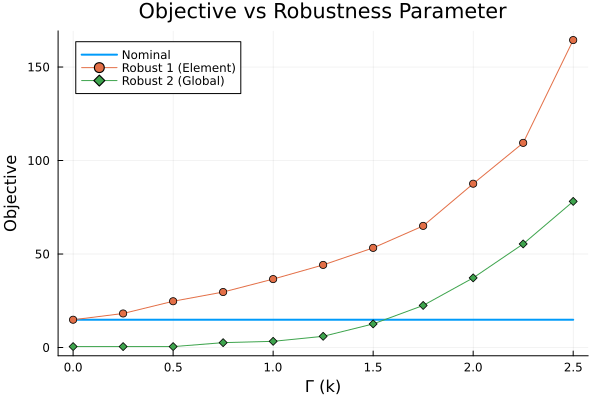

In [71]:
p_obj_all = plot(
    k_values, objectives_nominal,
    label="Nominal", linewidth=2
)

plot!(p_obj_all,
    k_values, objectives,
    label="Robust 1 (Element)", markershape=:circle
)

plot!(p_obj_all,
    k_values, objectives_global,
    label="Robust 2 (Global)", markershape=:diamond
)

xlabel!("Γ (k)")
ylabel!("Objective")
title!("Objective vs Robustness Parameter")
display(p_obj_all)


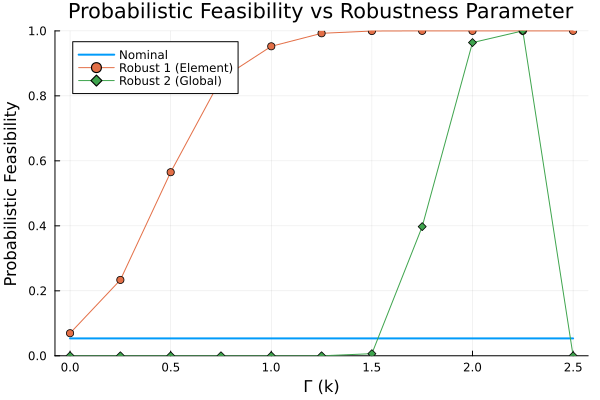

In [72]:
p_feas_all = plot(
    k_values, prob_feasible_nominal,
    label="Nominal", linewidth=2, ylim=(0,1)
)

plot!(p_feas_all,
    k_values, prob_feasible,
    label="Robust 1 (Element)", markershape=:circle
)

plot!(p_feas_all,
    k_values, prob_feasible_global,
    label="Robust 2 (Global)", markershape=:diamond
)

xlabel!("Γ (k)")
ylabel!("Probabilistic Feasibility")
title!("Probabilistic Feasibility vs Robustness Parameter")
display(p_feas_all)
